In [1]:
import nexradaws
import tempfile
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyart
from datetime import datetime, timedelta
import numpy as np
import pytz
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Central lat/lon of ARM SGP site 
lat_sgp = 36.607322
lon_sgp = -97.487643

In [3]:
# Create temp file, connect to NEXRAD AWS, request files by date & station ID
templocation = tempfile.mkdtemp()
conn = nexradaws.NexradAwsInterface()
#scans = conn.get_avail_scans(2019, 11, 10, 'KVNX')
scans = conn.get_avail_scans(2019, 8, 22, 'KVNX')

In [4]:
# Download selected volume scans
num_scans = scans[100:103]
localfiles = conn.download(num_scans, templocation)

scan_times = []
ref = []
count = 0

# Loop through downloaded scans
for scan in localfiles.iter_success():
        
    # Pyart doesn't like or can't seem to read in the MDM files so I'm ignoring them
    if 'MDM' in str(scan): 
        count+=1
    
    else:
        print('Reading in: '+scan.filename)
    
        # Read in the selected volume scans (that don't end in MDM)
        radar = pyart.io.read(localfiles.success[count].filepath)
        
        # Grab the times of the scans for plotting
        t = scan.scan_time # UTC
        times = scan_times.append(t)
        
        # Loop through each sweep
        for x in radar.iter_slice():

            # Get lat/lon/alt of all the gates in the sweep
            lat = radar.gate_latitude['data'][x]
            lon = radar.gate_longitude['data'][x]
            alt = radar.gate_altitude['data'][x] # meters

            # Calculate lat/lon of the gate closest to ARM SGP site
            dist = np.sqrt((lat - lat_sgp)**2 + (lon - lon_sgp)**2)
            min_idx = np.where(dist == dist.min())
            lat_lcn = lat[min_idx]
            lon_lcn = lon[min_idx]
            height = alt[min_idx]

            # Get reflectivity value at that lat/lon
            reflectivity = radar.fields['reflectivity']['data'][min_idx[0], min_idx[1]]
            ref.append(reflectivity)
            print('Lat,lon,hgt,ref of the gate closest to SGP site:', lat_lcn, lon_lcn, height, reflectivity)
        
        count+=1    

Downloaded KVNX20190822_085730_V06
Downloaded KVNX20190822_084514_V06
Downloaded KVNX20190822_085122_V06
3 out of 3 files downloaded...0 errors
Reading in: KVNX20190822_084514_V06
Lat,lon,hgt,ref of the gate closest to SGP site: [36.60864307] [-97.48846374] [1083.] [37.0]
Lat,lon,hgt,ref of the gate closest to SGP site: [36.60879042] [-97.48841587] [1083.] [30.0]
Lat,lon,hgt,ref of the gate closest to SGP site: [36.60873439] [-97.48852411] [1495.] [44.0]
Lat,lon,hgt,ref of the gate closest to SGP site: [36.60897965] [-97.48844301] [1489.] [25.0]
Lat,lon,hgt,ref of the gate closest to SGP site: [36.6086872] [-97.48867441] [1941.] [9.5]
Lat,lon,hgt,ref of the gate closest to SGP site: [36.6087854] [-97.4886425] [1941.] [25.0]
Lat,lon,hgt,ref of the gate closest to SGP site: [36.60540028] [-97.48705746] [2447.] [9.0]
Lat,lon,hgt,ref of the gate closest to SGP site: [36.60534165] [-97.48739894] [3081.] [8.5]
Lat,lon,hgt,ref of the gate closest to SGP site: [36.60545917] [-97.48782443] [380

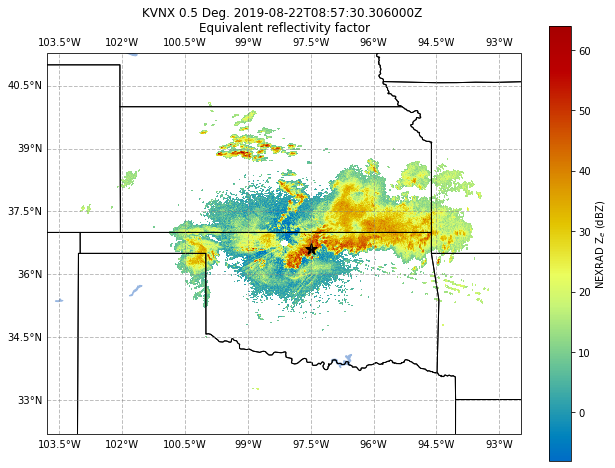

In [5]:
# Plot 
fig = plt.figure(figsize=[10,10])

ax = plt.axes(projection=ccrs.PlateCarree())

display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64, ax=ax, embelish=False, colorbar_flag=False)

cbar = plt.colorbar(mappable=display.plots[0], fraction=.1, shrink=.8, label='NEXRAD Z$_e$ (dBZ)')

grid = ax.gridlines(draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

grid.ylabels_right = False
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES, zorder=0)
#plt.scatter(lon_lcn, lat_lcn, marker='o', color='red', s=15)
plt.scatter(lon_sgp, lat_sgp, marker='*', color='black', s=150)

In [6]:
#radar.info()

In [7]:
# Get gate height array for plotting
gate_height = []

for y in radar.iter_slice():
    lat = radar.gate_latitude['data'][y]
    lon = radar.gate_longitude['data'][y]
    height = radar.gate_altitude['data'][y] # meters
    dist = np.sqrt((lat - lat_sgp)**2 + (lon - lon_sgp)**2)
    min_idx = np.where(dist == dist.min())
    hgt = height[min_idx]
    gate_height.append(hgt)
print(gate_height)

[array([1083.]), array([1083.]), array([1489.]), array([1489.]), array([1941.]), array([1941.]), array([2447.]), array([3081.]), array([3744.]), array([4663.]), array([5864.]), array([7222.]), array([8884.]), array([11004.]), array([13174.]), array([15288.]), array([18250.]), array([21459.])]


In [8]:
print(scan_times)

[datetime.datetime(2019, 8, 22, 8, 45, 14, tzinfo=<UTC>), datetime.datetime(2019, 8, 22, 8, 51, 22, tzinfo=<UTC>), datetime.datetime(2019, 8, 22, 8, 57, 30, tzinfo=<UTC>)]


TypeError: Dimensions of C (54, 1) are incompatible with X (3) and/or Y (18); see help(pcolormesh)

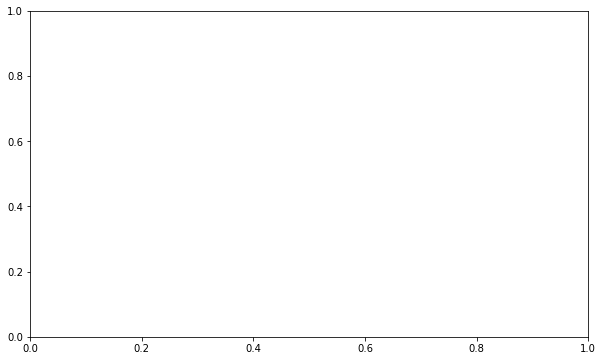

In [9]:
# Ideally I think you'd plot time-height plot using something like this,
# but the arrays I'm using don't make sense here and I can't come up with a better way
fig = plt.figure(figsize = [10,6])
plt.pcolormesh(scan_times, gate_height, ref,
               vmin = -10, vmax = 64, cmap = pyart.graph.cm.NWSRef)
print(dt)